In [1]:
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import networkx as nx
import gym 
from tqdm import tqdm 
from collections import deque
import seaborn as sns
from src.agents.UCB import UCB
from src.agents.NUCB import NUCB
from src.agents.etc import ExploreThenCommit
from src.environment.env_example import StochasticEnvironmentExample, BestOfBothWorldEnvironment
from src.environment.stochastic_env import StochasticEnvironment
from src.utils.experiment import plot_regret

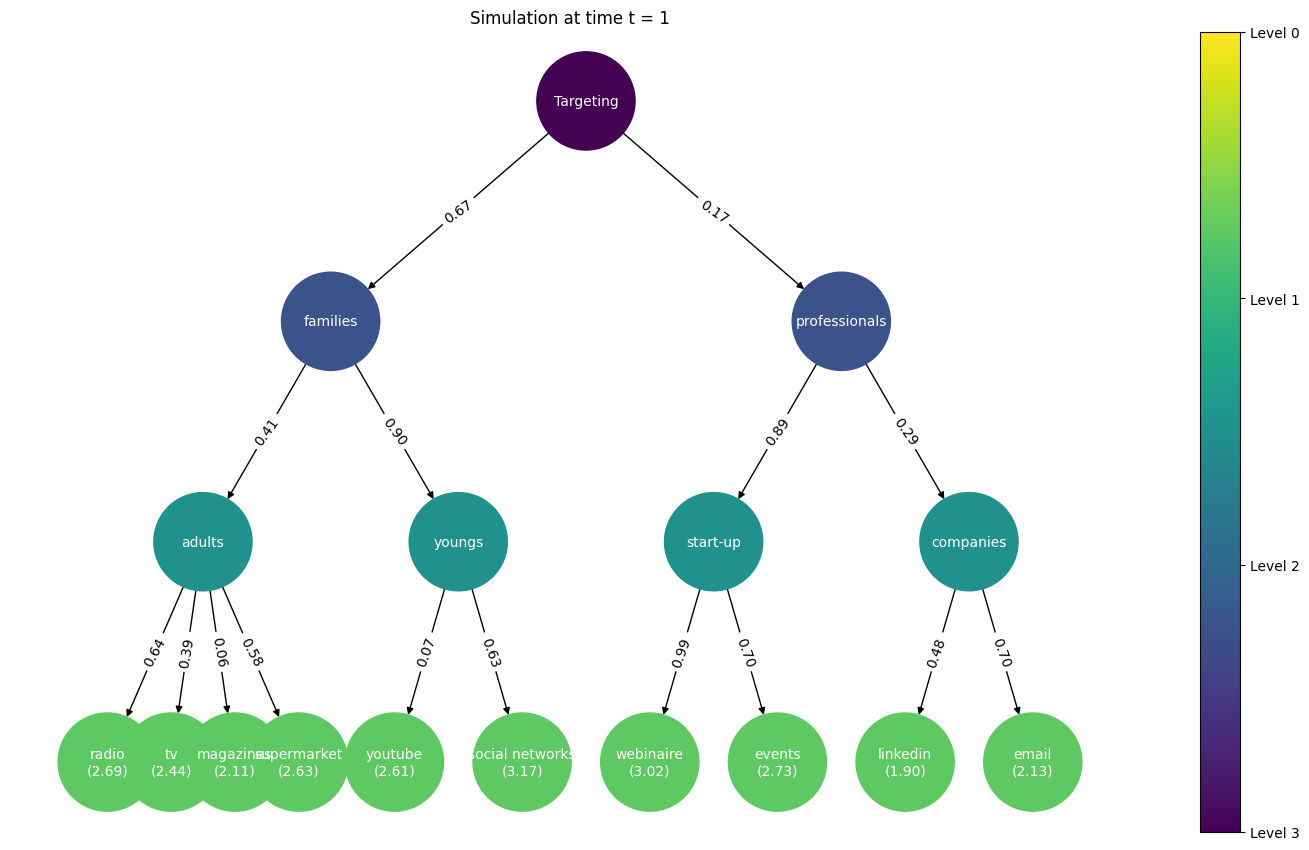

In [4]:
T = 1000  # Finite Horizon
N = 50  # Monte Carlo simulations
q = 10  #choice of percentile display
mus = [0, 
       [1.6, 2.7, 1.5],  # Layer 1
       [[0.3, 0.4], [0.9, 0.6], [0.6, 0.1, 0.4]],  # Layer 2
       [[[0.1, 0.3, 0.11, 0.32], [0.2, 0.8]], [[0.9, 0.25], [0.4, 0.1]], [[0.1, 0.8], [0.3, 0.03], [0.7, 0.01]]] # Layer 3
       ]
var = 1

# Framework for the experiments
env = BestOfBothWorldEnvironment()
env.tree.visualize_tree(1)
action_set = env.get_action_set()

In [19]:
import scipy.optimize as opt

class TsallisInf:
  "Assuming the rewards are in [0,1]"
  def __init__(self, action_set):
    self.action_set = action_set 
    self.K = len(self.action_set)
    self.alpha = .5
    self.eps = 1
    self.inverse_exponent = 1.0 / (self.alpha - 1.0)
    self.reset()   

  def PSI_t(self, w):
    return - np.sum(
                    [
                    (w[i]**self.alpha - self.alpha*w[i]) /
                    (self.alpha*(1-self.alpha)*self.eps) 
                    for i in range(self.K)
                    ]
                    )  / self.eta_t

  def reset(self, seed=None):
    self.rng = np.random.RandomState(seed) 
    self.total_loss = 0
    self.t = 0  
    self.eta_t = 2
    self.L_hat = np.zeros(self.K)
    self.weights = np.full(self.K, 1. / self.K)
    self.x = 1 / 2 * self.K

  def get_action(self, t):
    self.t += 1
    if t!=self.t:
      print("Error in the algorithm")
    self.eta_t = 2 / np.sqrt(max(1, self.t))
    action = np.random.choice(self.K, p=self.weights)
    return action

  def receive_reward(self, arm, reward):
    biased_loss = 1.0 - reward 
    unbiased_loss = biased_loss / self.weights[arm]  # RV
    self.L_hat[arm] += unbiased_loss  #update loss

    def objective_function(x):
      return (np.sum( (self.eta_t * (self.L_hat - x)) ** self.inverse_exponent ) - 1) ** 2

    result_of_minimization = opt.minimize_scalar(objective_function)
    x = result_of_minimization.x
    new_weights = (self.eta_t * (self.L_hat - x)) ** self.inverse_exponent
    if not np.all(np.isfinite(new_weights)):
        new_weights[~np.isfinite(new_weights)] = 0  
    if np.isclose(np.sum(new_weights), 0):
        new_weights[:] = 1.0

    new_weights /= np.sum(new_weights)
    self.weights =  new_weights
    """ 
    new_weights = 4 * (self.eta_t * (self.L_hat - self.x))**(-2)
    self.x -= (np.sum(new_weights) - 1) / (self.eta_t * np.sum([new_weights[i]**(3/2) for i in range(self.K)]))
    self.weights = new_weights / np.sum(new_weights)
    print(new_weights)
    """
    return unbiased_loss

  def nested(self):
    return False

  def name(self):
    return 'TsallisInf' 

Best arm is:  radio


Playing over time:   0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_37259/1732814756.py:45: RuntimeWarning: divide by zero encountered in power
  return (np.sum( (self.eta_t * (self.L_hat - x)) ** self.inverse_exponent ) - 1) ** 2
Playing over time: 100%|██████████| 1000/1000 [00:01<00:00, 623.55it/s]


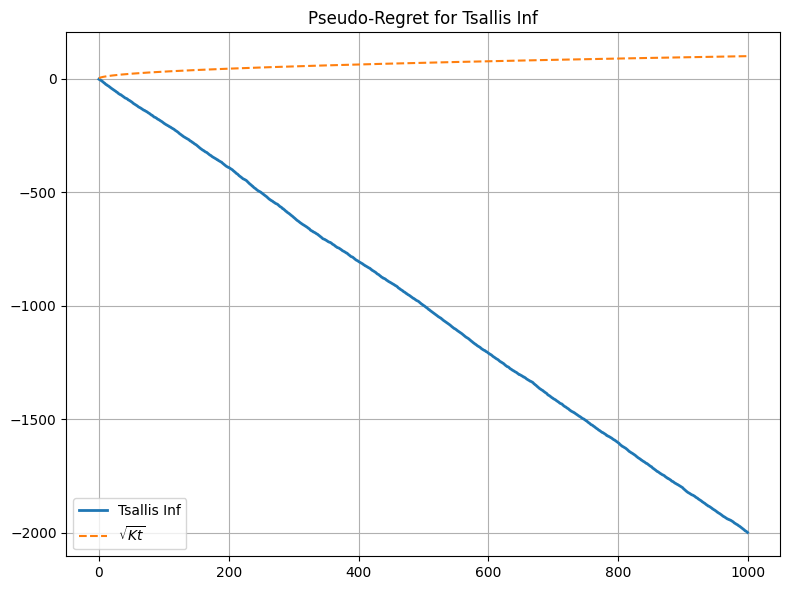

In [24]:
def play_tsallis(T):
    """ Assuming the reward are in [0,1]"""
    env = BestOfBothWorldEnvironment()
    best_path, best_reward = env.get_best_strategy_reward()
    print("Best arm is: ", best_path[-1])
    action_set = env.get_action_set()
    K = len(action_set)
    agent = TsallisInf(action_set)
    pseudo_regret = []
    for t in tqdm(range(1, T+1), desc="Playing over time"):
        arm_t = agent.get_action(t)
        #print(action_set[arm_t].name)
        mean = env.get_reward_mu(arm_t)
        received_reward = env.get_reward(arm_t)
        unbiased_loss = agent.receive_reward(arm_t, received_reward)
        env.step()
        #pseudo_regret.append(unbiased_loss - (1 - best_reward))
        pseudo_regret.append(best_reward - received_reward)

    plt.figure(figsize=(8,6))
    plt.plot(np.cumsum(pseudo_regret), label="Tsallis Inf", linewidth=2)
    plt.plot([np.sqrt(K * t) for t in range(1, T+1)], label=r"$\sqrt{K t}$", linestyle="--")
    plt.title("Pseudo-Regret for Tsallis Inf")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

play_tsallis(T)